In [18]:
# %pip install matplotlib
# %pip install pandas
# %pip install tensorflow-macos
# %pip install sklearn
# %pip install seaborn
# %pip install openpyxl
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn import linear_model
import warnings
import seaborn as sns
import matplotlib
from keras import regularizers
from sklearn.ensemble import RandomForestRegressor\

from sklearn import svm
from sklearn.linear_model import lasso_path, enet_path
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd #data managenmeent
warnings.filterwarnings(action='once')
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

'''# load the data
X = # your data here

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit the one-class SVM model
clf = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
clf.fit(X_scaled)

# predict the labels for the data
y_pred = clf.predict(X_scaled)

# identify the outlier data points
outliers = X_scaled[y_pred == -1]

# remove the outlier data points from the original dataset
clean_data = X_scaled[y_pred != -1]'''

"# load the data\nX = # your data here\n\n# Scale the data\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# fit the one-class SVM model\nclf = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)\nclf.fit(X_scaled)\n\n# predict the labels for the data\ny_pred = clf.predict(X_scaled)\n\n# identify the outlier data points\noutliers = X_scaled[y_pred == -1]\n\n# remove the outlier data points from the original dataset\nclean_data = X_scaled[y_pred != -1]"

In [19]:
# Dataset import
dataset_path = r'./dataset.xlsx'
raw_dataset = pd.read_excel(dataset_path, na_values="?", comment='\t')
dataset = raw_dataset.copy()
dataset=dataset.drop(columns=['Sintering Temperature','Sintering Pressure (Mpa)',\
                             'Sintering Time (min)', 'Sintering Method', 'Oxidation Test', 'Time@Temp (min)','Atmospheric Prerssure',\
                                'Oxygen Partial Pressure','Atmospheric Conditions','Flow Rate (cm3/min)','TiB2','LaB6' ])
#'Mean_Grain_Size' and 'Relative_Density'
dataset.dropna(subset='Oxide Thickness (um)',inplace=True)

Oxide Thickness (um)    1.000000
MoSi2                   0.258750
Time@Temp (s)           0.228146
TaSi2                   0.126422
TaC                     0.076278
ZrC                     0.015568
ZrB2                   -0.016200
HfC                    -0.039621
SiC                    -0.055804
Mean Grain Size (um)   -0.212423
Temperature (C)        -0.326326
Relative Density (%)   -0.354873
Name: Oxide Thickness (um), dtype: float64


C:\Users\gbiancoa\AppData\Local\Temp\ipykernel_73588\4271815785.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


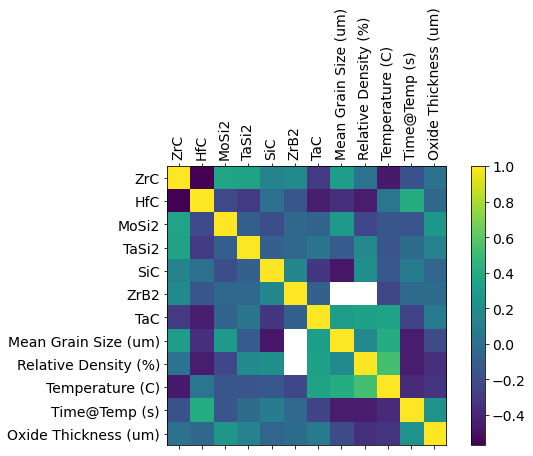

In [20]:
corr_matrix = dataset.corr()
print(corr_matrix["Oxide Thickness (um)"].sort_values(ascending=False))

f = plt.figure(figsize=(9, 5))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
plt.tight_layout()

cb.ax.tick_params(labelsize=14)

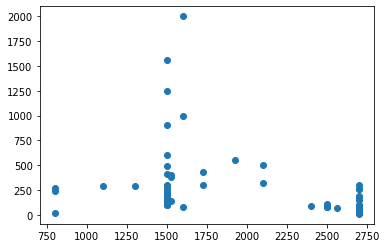

In [21]:
dataset = dataset.dropna(subset=['Oxide Thickness (um)'])
dataset.isna().sum()
dataset
plt.scatter(dataset['Temperature (C)'], dataset['Oxide Thickness (um)'])

In [22]:
#Preprocessing
#split train-test
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)
train_dataset
test_dataset.head()


,Composition,ZrC,HfC,MoSi2,TaSi2,SiC,ZrB2,TaC,Mean Grain Size (um),Relative Density (%),Temperature (C),Time@Temp (s),Oxide Thickness (um)
17,HfC - 34% SiC,0,66,0,0,34,0,0,0.48,100.0,2700.0,300.0,100.09
20,HfC - 34% SiC,0,66,0,0,34,0,0,0.48,100.0,2700.0,1800.0,258.84
24,HfC,0,100,0,0,0,0,0,6.80,96.7,2700.0,60.0,36.00
28,HfC - 20% TaC,0,80,0,0,0,0,20,6.20,97.8,2700.0,180.0,29.00
30,HfC - 50% TaC,0,50,0,0,0,0,50,3.80,98.2,2700.0,60.0,9.00


In [23]:
# In[4]: Separate Targets from features  Dataset
train_stats = train_dataset.describe()
train_stats.pop('Oxide Thickness (um)')
train_stats = train_stats.transpose()
train_labels = train_dataset.pop('Oxide Thickness (um)')
test_labels = test_dataset.pop('Oxide Thickness (um)')


In [24]:
# spacy - do their own embedding
# Word embedding - word2vec
# normalization - minmax

# In[5]: Normalization, This could change
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
imptrain = SimpleImputer(missing_values=np.nan, strategy='mean')
imptest = SimpleImputer(missing_values=np.nan, strategy='mean')

train_composition = train_dataset.pop('Composition')
test_composition = test_dataset.pop('Composition')



In [25]:
Train_scaler = MinMaxScaler()
Test_scaler = MinMaxScaler()

normed_train_data = Train_scaler.fit_transform(train_dataset)
normed_test_data = Test_scaler.fit_transform(test_dataset)

imptrain.fit(normed_train_data)
imptest.fit(normed_test_data)

normed_train_data = imptrain.transform(normed_train_data)
normed_test_data = imptest.transform(normed_test_data)
print(f'shape be fore input tranformation: {normed_test_data.shape}')
print(normed_train_data.shape)

def input_transformation(df):
   # Apply polynomial expansion
   poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
   X_poly = poly.fit_transform(df)
   # Apply interaction term
   interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
   X_interaction = interaction.fit_transform(df)
   # Apply log transformation
   #X_log = np.log(df)
   df = np.concatenate([df, X_poly, X_interaction], axis=1)
   return df
normed_train_data = input_transformation(normed_train_data)
normed_test_data = input_transformation(normed_test_data)


ndf = pd.DataFrame(normed_train_data)
ndf.shape

shape be fore input tranformation: (13, 11)
(50, 11)


(50, 154)

In [26]:

test_composition

17     HfC - 34% SiC
20     HfC - 34% SiC
24               HfC
28     HfC - 20% TaC
30     HfC - 50% TaC
32     HfC - 50% TaC
33      HfC- 80% TaC
38               TaC
48      TaC - 5% GNP
56              HfC 
65    HfC - 10% SiCN
66    HfC - 10% SiCN
76       1TaC - 4HfC
Name: Composition, dtype: object

In [27]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


# Random Forest regressor with Gridsearch
param_grid = {
    "n_estimators": [10,50,60,65,67,68],
    "criterion": ['absolute_error','mse'],
    "max_features": [1.0],
    "max_depth": [None, 10, 15, 20, 25,50],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 2],
    'max_leaf_nodes' : [10,57,60,65,67,80]
              }   
rfr = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, n_jobs=-1, cv=5).fit(normed_train_data, train_labels)
# rfr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=None,bootstrap=True, oob_score=False, n_jobs=1, random_state=2).fit(normed_train_data, train_labels) 

In [28]:

#Linear Models
Ridge = linear_model.Ridge(alpha=.6).fit(normed_train_data, train_labels) # Ridge
Lasso = linear_model.Lasso(alpha=0.1).fit(normed_train_data, train_labels) # Lasso Linear Mode
Ols = linear_model.LinearRegression().fit(normed_train_data, train_labels) # Ordinary Least Squares

#Gaussian Process regressor
# define a prior i.e. a distribution of functions-what this really means: choose a kernel and kernel hyperparameters
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 10.0)) + 1.0 * WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 10.0))
kernel = 100000.0 * RationalQuadratic(length_scale=1e-05, alpha=100000.0)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,optimizer='fmin_l_bfgs_b').fit(normed_train_data, train_labels)


Knr = KNeighborsRegressor().fit(normed_train_data, train_labels)

Mlp = MLPRegressor(hidden_layer_sizes=(250,),activation='tanh', solver='adam',learning_rate='adaptive', alpha =0.001 ,random_state=1, max_iter=500).fit(normed_train_data, train_labels)

Svr = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1).fit(normed_train_data, train_labels)
Adaboost = AdaBoostRegressor(random_state=0, n_estimators=100).fit(normed_train_data, train_labels)
GBr = GradientBoostingRegressor(random_state=0).fit(normed_train_data, train_labels)
Vregr = VotingRegressor([('RFR', rfr), ('SVM',Svr), ('Mlp',Mlp), ('Ridge',Ridge),('AdaBoost', Adaboost), ('Gradient Boosting', GBr)]).fit(normed_train_data, train_labels)


c:\Users\gbiancoa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+04, tolerance: 7.486e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\gbiancoa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\gbiancoa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and cal

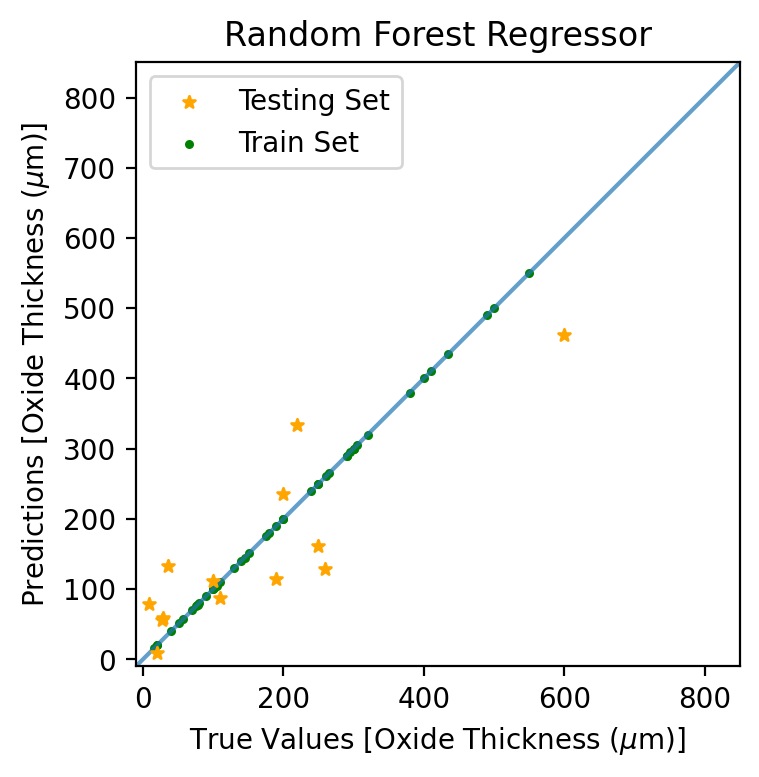

In [53]:
# Testing
test_dataset["label"] = test_labels
#predictions is tets set
rfr_predict = rfr.predict(normed_test_data).flatten()
ridge_predict = Ridge.predict(normed_test_data).flatten()
LAsso_predict = Lasso.predict(normed_test_data).flatten()
Ols_predict = Ols.predict(normed_test_data).flatten()
GPR_predict = gp.predict(normed_test_data).flatten()
KNR_predict = Knr.predict(normed_test_data).flatten()
Mlp_predict = Mlp.predict(normed_test_data).flatten()
SVR_predict = Svr.predict(normed_test_data).flatten()
Adabbost_predict = Adaboost.predict(normed_test_data).flatten()
GBr_predict = GBr.predict(normed_test_data).flatten()
Voting_predict = Vregr.predict(normed_test_data)

test_dataset["Random Forest Regr"] = rfr_predict
test_dataset["Ridge"] = ridge_predict
test_dataset["Lasso"] = LAsso_predict
test_dataset["Ord. least ssqr."] = Ols_predict
test_dataset["KNR"] = KNR_predict
test_dataset["Mlp"] = Mlp_predict
test_dataset["Guassian Pros."] = GPR_predict
test_dataset['SVM'] = SVR_predict
test_dataset["AdaBoost "] = Adabbost_predict
test_dataset["Gradient Boosting "] = GBr_predict
test_dataset["Voting"] = Voting_predict
#ensemble
avg = np.add(rfr_predict,np.add(ridge_predict, GPR_predict))/3
test_dataset.to_csv("test_dataset_pred.csv")

plt.figure(dpi=200)
plt.scatter(test_labels, avg, c='orange',s=20, marker='*',zorder=2, label="Testing Set")
plt.scatter(train_labels, train_labels, c='green',s=5, marker='o',zorder=1, label="Train Set")
plt.legend()
plt.title("Random Forest Regressor")
plt.xlabel(r'True Values [Oxide Thickness ($\mu$m)]')
plt.ylabel(r'Predictions [Oxide Thickness ($\mu$m)]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,850])
plt.ylim(-10,850)
_ = plt.plot([-1000, 1000], [-1000, 1000],zorder=1, alpha = 0.7)
plt.savefig('rfrpred')
plt.show()


In [54]:
MAE = {'RFR': [mean_absolute_error(test_labels,rfr_predict)],
     'Ridge': [mean_absolute_error(test_labels,ridge_predict)],
     'Lasso': [mean_absolute_error(test_labels,LAsso_predict)],
     'Ord. least ssqr.': [mean_absolute_error(test_labels,Ols_predict)],
     'KNR': [mean_absolute_error(test_labels,KNR_predict)],
     'Mlp': [mean_absolute_error(test_labels,Mlp_predict)],
      'GPros': [mean_absolute_error(test_labels,GPR_predict)],
      'SVM Regression': [mean_absolute_error(test_labels,SVR_predict)],
      'AdaBoost Regressor':[mean_absolute_error(test_labels,Adabbost_predict)],
      'Gradient Boosting Regressor':[mean_absolute_error(test_labels,GBr_predict)],
      'Voting': [mean_absolute_error(test_labels,Voting_predict)],
      "Ensemmble": [mean_absolute_error(test_labels,avg)]}

MAE = pd.DataFrame(data=MAE)
print('Mean absulote error: ', mean_absolute_error(test_labels,rfr_predict))
print(f'best MAE: {MAE.idxmin(axis=1)}, {MAE.min(axis=1)}')
print(MAE)
R2 = {'RFR': [r2_score(test_labels,rfr_predict)],
     'Ridge': [r2_score(test_labels,ridge_predict)],
     'Lasso': [r2_score(test_labels,LAsso_predict)],
     'Ord. least ssqr.': [r2_score(test_labels,Ols_predict)],
     'KNR': [r2_score(test_labels,KNR_predict)],
     'Mlp': [r2_score(test_labels,Mlp_predict)],
      'GPros': [r2_score(test_labels,GPR_predict)],
      'SVM Regression': [r2_score(test_labels,SVR_predict)],
      'AdaBoost Regressor':[r2_score(test_labels,Adabbost_predict)],
      'Gradient Boosting Regressor':[r2_score(test_labels,GBr_predict)],
      'Voting': [r2_score(test_labels,Voting_predict)],
      "Ensemmble": [r2_score(test_labels,avg)]}
R2 = pd.DataFrame(data=R2)

print(f'Coefficient of Determination: {r2_score(test_labels,rfr_predict)}')
print(f'best fit:{R2.idxmax(axis=1)},{R2.max(axis=1)}')
print(R2)

Mean absulote error:  139.77307692307693
best MAE: 0    Ensemmble
dtype: object, 0    65.451154
dtype: float64
          RFR      Ridge       Lasso  Ord. least ssqr.        KNR         Mlp  \
0  139.773077  84.885805  171.594565       1746.795636  91.426308  119.532142   

        GPros  SVM Regression  AdaBoost Regressor  \
0  157.763846       80.687809          158.259736   

   Gradient Boosting Regressor      Voting  Ensemmble  
0                    158.12658  111.033236  65.451154  
Coefficient of Determination: -0.04594563468716939
best fit:0    Ensemmble
dtype: object,0    0.746023
dtype: float64
        RFR     Ridge     Lasso  Ord. least ssqr.       KNR       Mlp  \
0 -0.045946  0.533611 -1.102727       -262.633605  0.163552 -0.045069   

      GPros  SVM Regression  AdaBoost Regressor  Gradient Boosting Regressor  \
0 -1.024076        0.439422           -0.364144                    -0.587163   

     Voting  Ensemmble  
0  0.293316   0.746023  


C:\Users\gbiancoa\AppData\Local\Temp\ipykernel_73588\4105787911.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(['','1500',''])


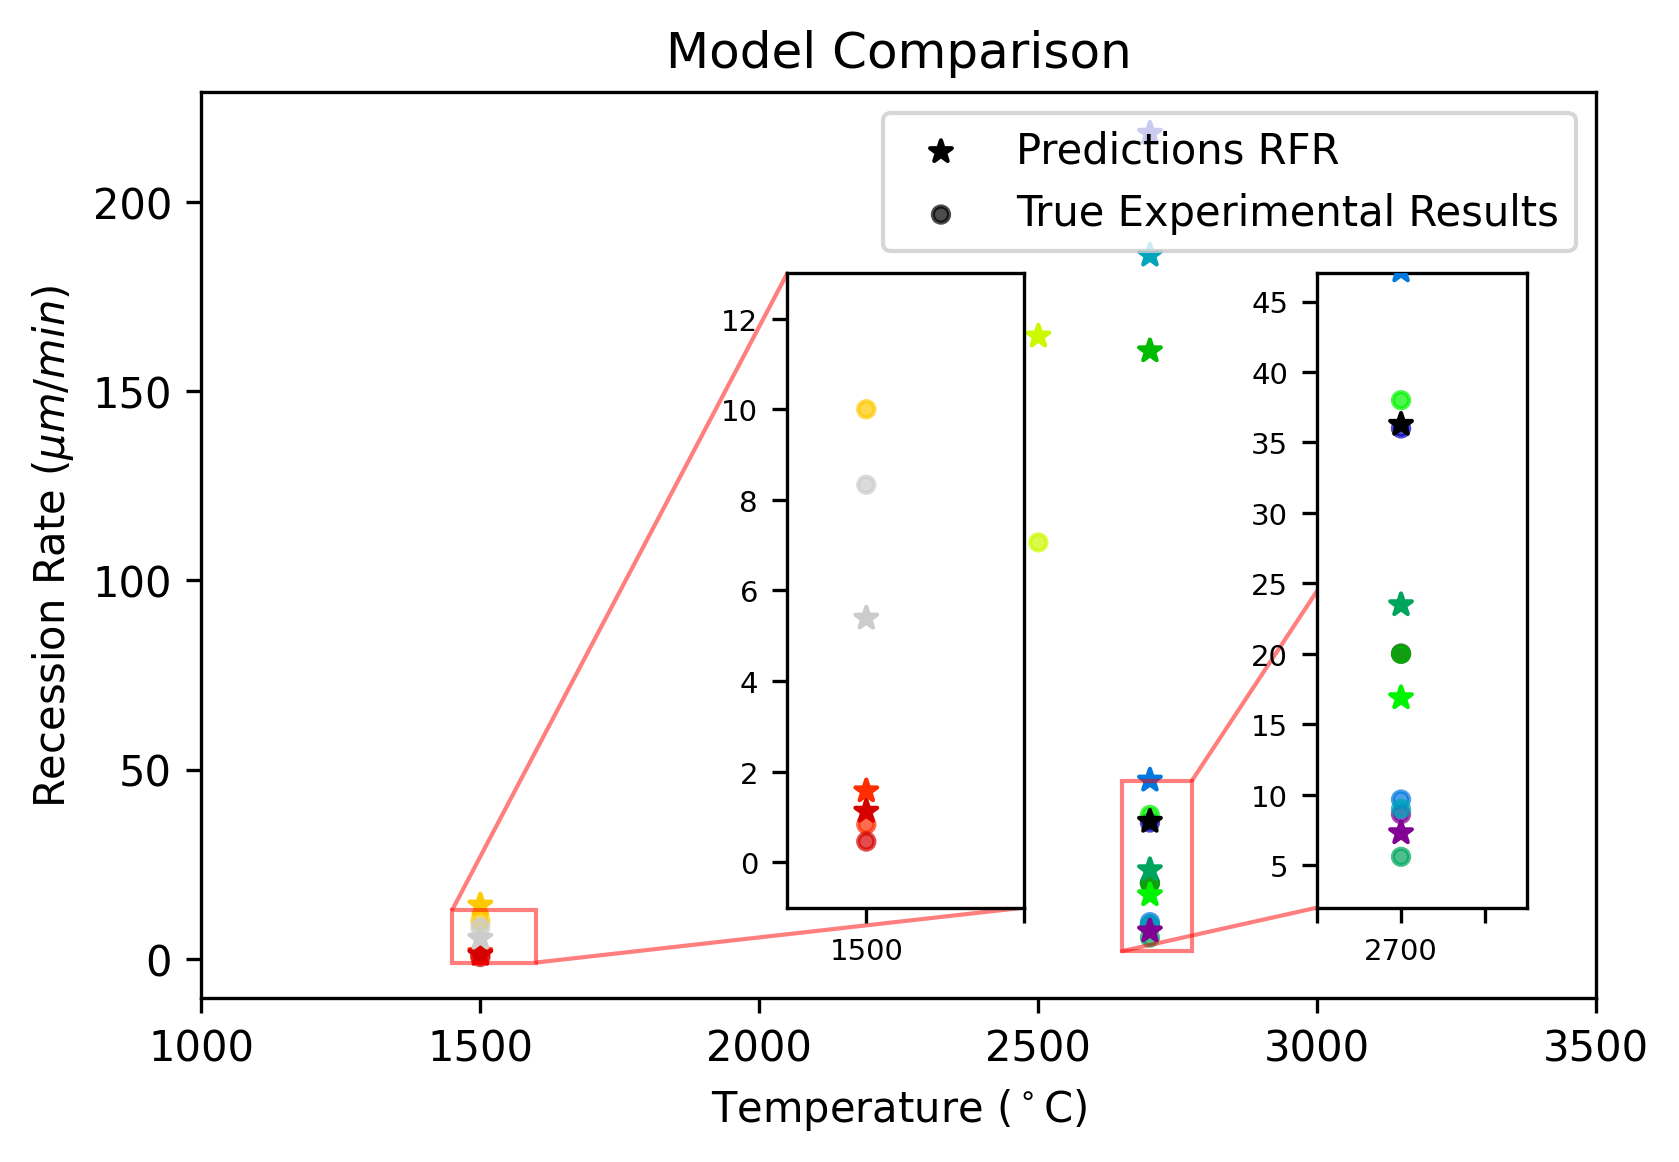

In [55]:
#%pip install adjustText
from adjustText import adjust_text
d = {'True values': test_labels, 'Pred1': rfr_predict, 'temperature': test_dataset["Temperature (C)"], 'time': test_dataset["Time@Temp (s)"], 'composition': test_composition.values}
pdp = pd.DataFrame(data=d)
pdp = pdp.sort_values(by=['temperature'], ascending=False)
cmap = plt.get_cmap('nipy_spectral')
composition = pdp['composition']
colors = cmap(np.linspace(0,1,len(pdp['composition'])))
fig, ax = plt.subplots(dpi=300)
plot1= plt.scatter(pdp['temperature'],(pdp['Pred1']*60)/pdp['time'],  c=colors,label='Predictions RFR',s=30,marker="*", zorder=3)
#plt.plot(pdp['temperature'],pdp['True values'], c='g', label='True Data Line',linewidth=1, zorder=1, alpha=0.5 )
plot2 = plt.scatter(pdp['temperature'],(pdp['True values']*60)/pdp['time'], c=colors, label='True Experimental Results',s=15, zorder=2, alpha=0.7 )

texts = []
for i in range(len(pdp['Pred1'])):
    continue
    texts.append(plt.annotate(13-i, xy=(pdp['temperature'].values[i],(pdp['Pred1'].values[i])*60/pdp['time'].values[i]), xytext=(pdp['temperature'].values[i],(pdp['Pred1'].values[i])*60/pdp['time'].values[i]),size=10, rotation =16, arrowprops=dict(arrowstyle='-', color='red')))
adjust_text(texts)
# Big regoin Size and plot
axins = ax.inset_axes([0.42, 0.1, 0.17, 0.7])
axins.scatter(pdp['temperature'],(pdp['Pred1']*60)/pdp['time'],  c=colors,label='Predictions RFR',s=30,marker="*", zorder=3)
axins.scatter(pdp['temperature'],(pdp['True values']*60)/pdp['time'], c=colors, label='True Experimental Results',s=15, zorder=2, alpha=0.7 )
# sub region of the original image
x1, x2, y1, y2 = 1450, 1600, -1, 13
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis="x", labelsize=7)
axins.tick_params(axis="y", labelsize=7)
axins.set_xticklabels(['','1500',''])
ax.indicate_inset_zoom(axins, edgecolor="red")

# Big regoin Size and plot
axins = ax.inset_axes([0.8, 0.1, 0.15, 0.7])
axins.scatter(pdp['temperature'],(pdp['Pred1']*60)/pdp['time'],  c=colors,label='Predictions RFR',s=30,marker="*", zorder=3)
axins.scatter(pdp['temperature'],(pdp['True values']*60)/pdp['time'], c=colors, label='True Experimental Results',s=15, zorder=2, alpha=0.7 )
# sub region of the original image
x1, x2, y1, y2 = 2650, 2775, 2, 47
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis="x", labelsize=7)
axins.tick_params(axis="y", labelsize=7)
axins.set_xticklabels(['','2700',''])
ax.indicate_inset_zoom(axins, edgecolor="red")

plt.xlim(1000,3500)
plt.ylim()
plt.title('Model Comparison')
plt.ylabel(r'Recession Rate ($\mu$$m/min)$')
plt.xlabel(r'Temperature ($^\circ$C)')
plt.legend(loc='upper right')
#plt.savefig('Comparepred')
plt.show()
#pdp.to_csv('pdp_results.csv')

In [31]:
# Cross validation
from sklearn.model_selection import cross_val_score
CVscore = {'RFR': [cross_val_score(rfr, normed_train_data, train_labels, cv=5)],
     'Ridge': [cross_val_score(Ridge, normed_train_data, train_labels, cv=5)],
     'Lasso': [cross_val_score(Lasso, normed_train_data, train_labels, cv=5)],
     'Ord. least ssqr.': [cross_val_score(Ols, normed_train_data, train_labels, cv=5)],
     'KNR': [cross_val_score(Knr, normed_train_data, train_labels, cv=5)],
     'Mlp': [cross_val_score(Mlp, normed_train_data, train_labels, cv=5)],
      'GPros': [cross_val_score(gp, normed_train_data, train_labels, cv=5)],
      'SVM Regression': [cross_val_score(Svr, normed_train_data, train_labels, cv=5)],
      'AdaBoost Regressor':[cross_val_score(Adaboost, normed_train_data, train_labels, cv=5)],
      'Gradient Boosting Regressor':[cross_val_score(GBr, normed_train_data, train_labels, cv=5)],
      'Voting': [cross_val_score(Vregr, normed_train_data, train_labels, cv=5)]}

CVscore

c:\Users\gbiancoa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


KeyboardInterrupt: 

In [ ]:
# Test Sobols ditribution dataset
path = r'sobols.csv'
sobols = pd.read_csv(path)
sobols.drop(['Unnamed: 0'], axis=1, inplace=True)
invsobols = Train_scaler.fit_transform(sobols)
invsobols = input_transformation(invsobols)
print(sobols.shape)

Sob_pred = pd.DataFrame(rfr.predict(invsobols))
Sob_pred
dfsobols = pd.concat([pd.DataFrame(sobols), Sob_pred], axis=1)
dfsobols.columns = ['ZrC','TiB2','HfC','LaB6','MoSi2','TaSi2','SiC','ZrB2','TaC','Mean Grain Size (um)',
                    'Relative Density (%)','Temperature (C)','Time@Temp (s)','Oxide Thickness (um)'] 
dfsobols.to_csv('sobols_predicts.csv')
dfsobols.head()

(1000, 11)


ValueError: Length mismatch: Expected axis has 12 elements, new values have 14 elements